In [6]:
import math
import logging
from typing import Union
from pathlib import Path
from urllib.parse import urlparse, parse_qsl, urlsplit

import pandas as pd
import seaborn as sb
import json
import requests
import fhirclient

from IPython.display import display, HTML
#fhir server clients and configuration
from fhirclient import client
import fhirclient.models.patient as p
import fhirclient.models.observation as o
import fhirclient.models.bundle as b


In [7]:
#Constants
HAPI_URL = 'http://hapi.fhir.org/baseR4'

# Testing connection to server
The fhirclinet library is used to simplify interaction between server responses.
First a simple test to retrieve a patient's name.


In [8]:
#Test library on HAPI-FHIR test server
resp = requests.get(HAPI_URL)
print(resp.json())

settings = {
    'app_id': 'fhir',
    'api_base': 'http://hapi.fhir.org/baseR4/'
}


#test a patient query
SMART = client.FHIRClient(settings=settings)    
patient = p.Patient.read('697505', SMART.server)
p_name = SMART.human_name(patient.name[0])
# 'Dorothy Mayer'
print('Patient Name:', p_name)

#Test sever connection
SMART.prepare()  # prints True after fet ching CapabilityStatement

{'resourceType': 'OperationOutcome', 'text': {'status': 'generated', 'div': '<div xmlns="http://www.w3.org/1999/xhtml"><h1>Operation Outcome</h1><table border="0"><tr><td style="font-weight: bold;">ERROR</td><td>[]</td><td><pre>This is the base URL of FHIR server. Unable to handle this request, as it does not contain a resource type or operation name.</pre></td>\n\t\t\t\t\t\n\t\t\t\t\n\t\t\t</tr>\n\t\t</table>\n\t</div>'}, 'issue': [{'severity': 'error', 'code': 'processing', 'diagnostics': 'This is the base URL of FHIR server. Unable to handle this request, as it does not contain a resource type or operation name.'}]}
Patient Name: Dorothy Mayer


True

## Search for observation in FHIR-SERVER
The function search_observation(...) is used to create a query to the FHIR server
it is mainly configure to work with observation codes (SNOMED, LOINC).

For this project the function can accept a subject id form the fhir server.
This variation is used in the app.py to retreive measurements of a patient and predict over them.

Observation    
code: 85354-9: LOINC CODE
value: Blood pressure panel with all children optional.
note: Will look for observations of blood preassure 

In [9]:

def search_observation(obs_code: str, server, subject= None ) -> pd.DataFrame:
    """ 
        Recibes a code conforming to SNOMED-CT 
        e.j. http://bioportal.bioontology.org/ontologies/SNOMEDCT/?p=classes&conceptid=http%3A%2F%2Fpurl.bioontology.org%2Fontology%2FSNOMEDCT%2F38341003&jump_to_nav=true

        Args:
            obs_code [str] -- SNOMED-CT or LOINC conforming code
            server   [   ] -- instance of fhirclient server
        
        Returns:
            iatros_df [pandas.DataFrame]
    """
    # Create search query
    payload = {'status' : 'final',
                'code': {'$and': [obs_code]},    
            }
    if subject is not None:
        payload['subject'] = subject
    fs = o.Observation.where(struct = payload)
    # Perfom query to receive a Bundle resourceType since it contains pagination link.
    bundle = fs.perform(server)
    #print(json.dumps(bundle.as_json(), indent=2))
    
    # Pass bundle to handel pagination and save entries in Dataframe
    iatros_df = handle_pagination(bundle)
    
    return iatros_df

## Pagination
To search for multiple values to use as training data set the query requires to handle paginated responses from the server.
- Each page returns 20 entries.
- The function read the entries and get the data of interest to append into smaller dataframes.
- The while loop runs while the response bundle has a pagination next.link
- Return a dataframe with all the acquired entries.

Note: 
During pagination the algorithm converts the bundle to a fhirclient object.
**However** after some pages the bundle conversion fails due to a fhir_comment param that the library is unable to handle.



In [10]:
def handle_pagination(bundle: fhirclient.models.bundle) -> pd.DataFrame:
    """
        Handles a resourceType: "Bundle" entries, if pagination
        link avalable iterates looking for next page entries and
        queries the server for the next page.

        Arguments:
            bundle -- fhirclient.models.bundle

        Returns:
            pandas.DataFrame -- A Data frame containing inputs from
                                 the paginated  requests.
    """
    frames = []
    #Keep requesting while pagination link exists
    while True:
        entries = [be.resource for be in bundle.entry] if bundle is not None and bundle.entry is not None else None
        print('Retrieved {}/{} entries...'.format(len(bundle.entry) if bundle.entry else 0, bundle.total if bundle.total else ' '))
        
        #Get a temp dataframe from current bundle entries
        temp_df =  append_entries_to_dataset(bundle)
        frames.append(temp_df)
        #Look for a pagination link
        if entries is not None and len(entries) > 0:
            next_link = get_next_link_in(bundle)  
            url_params = get_url_params(next_link)
            if next_link is not None:
                if len(url_params) > 1:
                    #Query for next page
                    response = requests.get(HAPI_URL, params=url_params)
                    if response.status_code == 200:
                        #Initialize a bundle object from request response as json
                        try: 
                            bundle = b.Bundle(response.json())
                        except Exception as e:
                            print('An error ocurred while creating Bundle object')
                            print(e)
                            print('Error query: ', next_link)
                            return pd.concat(frames)
            else:
                return pd.concat(frames)
        else:
             return pd.concat(frames)

def get_url_params(url:str):
    o = urlparse(url)
    query = parse_qsl(o.query)
    
    params = dict(parse_qsl(urlsplit(url).query))
    
    return params

def get_next_link_in(bundle):
    if bundle.link is not None:
        for link in bundle.link:
            if link.relation == 'next':
                return link.url
    else:
         return None

## Dataset filler
 This section creates a pandas Dataframe from a Query response.

 ### Problems
 I tried to use the SOMED-CT code to retreive patients with Hypertension disorder observations. However this code only return 2 entries which wherent enough for the model training.

[![Run in Postman](https://run.pstmn.io/button.svg)](https://app.getpostman.com/run-collection/933c23e950e1b35fcfd4)

### Solution
I added a small validation check for blodd pressure values under thes conditions, a True entry was added to the Hypertension column.


In [11]:
def append_entries_to_dataset(bundle)-> pd.DataFrame:
    columns = ['Patient_Ref','Dia','Sys','Units']
    d= []
    for entry in bundle.entry:
        row = {}
        resource = entry.resource
        subject_ref = resource.subject.reference.replace('Patient/','')
        for comp in resource.component:
            if comp.valueQuantity is not None and comp.valueQuantity is not float('nan'):
                bp_val = comp.valueQuantity.value
                bp_val_unit = comp.valueQuantity.unit
                if bp_val is not None:
                    if comp.code.text == "Diastolic Blood Pressure":
                        row['Dia'] = bp_val
                    elif comp.code.text == "Systolic Blood Pressure":
                        row['Sys'] = bp_val
            else:
                print('Non value quantity found')
                continue
            row['Units'] = bp_val_unit
            row['Patient_Ref'] = subject_ref 
                
        if ('Sys' in row.keys()) and ('Dia' in row.keys()):
            sistolic = row['Sys'] 
            diastolic = row['Dia'] 
            if 130 <= sistolic <= 139 and 80 <= diastolic <= 89:
                row['Hypertension'] = True
            elif sistolic >= 140 and diastolic >= 90 :
                row['Hypertension'] = True
            else:
                row['Hypertension'] = False  
           
        d.append(row)
    
    return pd.DataFrame(d)

# Run Query for observation (Blood pressure)

In [12]:
#Reuse SMART server instance
iatros_df = search_observation('85354-9', SMART.server)

#Test query for patient: 1598464  
#patient_df = search_observation('85354-9', SMART.server, subject='1598464')
#patient_df.head

Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20/  entries...
Retrieved 20

In [13]:
#display(HTML(iatros_df.to_html()))

# Final Dataframe pre-processing
- Remove rows with NaN values
- The index count repeats every 20 entries due to the filler function. So we just reset it and remove it for a more clear dataframe reading.
- Save the dataframe to a .cvs file this will make testing the training easier.


In [14]:
#Clean datasframe
'''Remove nan values'''
iatros_df = iatros_df.dropna()
'''Reset index count and remove it'''
iatros_df.reset_index(drop=True,inplace=True)
#display(HTML(iatros_df.to_html()))
iatros_df.to_csv('hypertension.csv',index=False)

## Binary classification

In [15]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.tabular.all import *
import torch
import torch.nn as nn

# Model trainin setup

We began by loading de previously obtained dataframe from a .csv. A small check is run to remove columns that are not needed for the training process.

A tabular loader from fastAi is being used to train. So we created and pass some preprocessing instructions such as Categorify to prevent errors in the boolean column and Normalize to normalize Blood pressure values.


In [18]:
iatros_df = pd.read_csv('hypertension.csv')

try: 
    iatros_df = iatros_df.drop(columns=['Units','Patient_Ref'])
except:
    print('Column not in dataframe')
    print('Available columns: ', iatros_df.columns)
#Config Tabular DataLoader:
cont_names = ['Dia','Sys',]
y_name = 'Hypertension'
procs = [Categorify, Normalize]
dls = TabularDataLoaders.from_df(iatros_df , procs=procs,cont_names=cont_names,y_names=y_name, y_block=CategoryBlock, bs=64)

splits = RandomSplitter(valid_pct= 0.2)(range_of(iatros_df))
dls.show_batch()


,Dia,Sys,Hypertension
0,83.0,113.0,False
1,83.0,123.0,False
2,80.0,122.0,False
3,71.0,105.0,False
4,76.0,118.0,False
5,74.0,129.0,False
6,79.0,110.0,False
7,72.0,124.0,False
8,86.0,126.0,False
9,82.0,138.0,True


# Define model
- Setup model directory and check for dir existence.
- Setup up a name for the final model to be exported (reused for weights)
- Setup the learner that Will try to infer the loss function based on our y_names



In [20]:
models_path = Path.cwd()
callbacks = [] 

if not models_path.is_dir():
    models_path.mkdir(exist_ok=True)
 
model_name = 'hypertension_model'
callbacks = [SaveModelCallback(every='improvement',
                                    monitor='val_loss', 
                                    name= model_name)]

learn = tabular_learner(dls,path=models_path, metrics=accuracy,callbacks=callbacks, splits=splits)


**Fit the model for 50 epochs using the 1cycle policy.**

In [21]:
learn.fit_one_cycle(50)
learn.save(file = model_name)
learn.export(fname=models_path/'hypertension_model.pkl', pickle_protocol=2)

Get the prediction dictionary to get some metrics:
- validation acccuracy = 99.41175842285156 %
- A confusion matrix to describe classification performance

The validation accuracy is 99.41175842285156 %.


,Dia,Sys,Hypertension,Hypertension_pred
0,-0.194216,0.007680,0.0,0.0
1,0.100628,-0.863315,0.0,0.0
2,1.132583,-1.589144,0.0,0.0
3,1.132583,-0.355235,0.0,0.0
4,-1.521015,-0.718149,0.0,0.0
5,4.081025,1.677086,1.0,1.0
6,-0.489060,1.023840,0.0,0.0
7,-0.931326,0.370594,0.0,0.0
8,-0.636482,0.878674,0.0,0.0


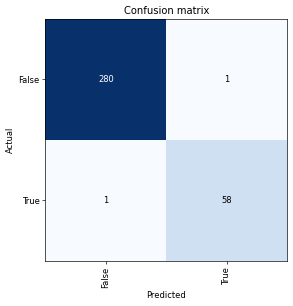

In [27]:

preds, targs = learn.get_preds()
acc = accuracy(preds, targs)
print('The validation accuracy is {} %.'.format(acc * 100))


interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize= (5,5),dpi=60)

learn.show_results()

# Test predict method on a row

The next section test the model o a sample row in the dataset. Any other row can be selected from **hypertension.csv**

### Note for testing porpouses:
The dataset rows have a gap of two agains the .csv file number of rows.

A way to select a row from file will be to:
    - select a row in the .csv
    - check file line number
    - substract 2 
    - add result to .iloc index

` dataframe row number  = .csv file row + 2 `

- If csv file line is 2 to select this row do:    
    `iatros_df_iloc[0]`
        
- ` iatros_df.iloc[20] ` will be in line 22 of .csv file

In [28]:
row, clas, probs = learn.predict(iatros_df.iloc[20])
row.show()
print('Class: {} \nProbabilities: {}'.format(clas,probs))

,Dia,Sys,Hypertension
0,113.999999,164.0,True


Class: 1 
Probabilities: tensor([1.3426e-05, 9.9999e-01])


In [34]:
'''

Ignore this cell, a buton to the the real problem query was added in the **Dataset Filler** section

'''
#This pagination link can't be converted and breaks the pagination. 

broken_url = 'http://hapi.fhir.org/baseR4?_getpages=300bdb01-0cdf-4349-9299-8304f540cc7c&_getpagesoffset=2320&_count=20&_pretty=true&_bundletype=searchset'
url_params = get_url_params(broken_url)

if len(url_params) > 1:
                #Query for next page
                response = requests.get(broken_url, params=url_params)
                #print(response.text)
               # print(json.dumps(response.json(), indent=2))
                
                if response.status_code == 200:
                    #Initialize a bundle object from request response as json
                    try: 
                        bundle = b.Bundle(response.json())
                    except Exception as e:
                        print('An error ocurred while creating Bundle object')
                        print(e)
                        
                